In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
from PIL import Image
from IPython.display import Image

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix


%matplotlib inline


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving winemag-data-130k-v2.csv to winemag-data-130k-v2.csv


In [ ]:
wine_data = pd.read_csv('/content/winemag-data-130k-v2.csv')
wine_data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [ ]:
wine_data.shape

(129971, 14)

In [ ]:
wine_data.describe()

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


In [ ]:
wine_data.isnull().values.any()

True

In [ ]:
wine_data[wine_data.duplicated(['title'], keep=False)].head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
11,11,France,"This is a dry wine, very spicy, with a tight, ...",NaN,87,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer
12,12,US,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini
13,13,Italy,This is dominated by oak and oak-driven aromas...,Rosso,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Masseria Setteporte 2012 Rosso (Etna),Nerello Mascalese,Masseria Setteporte


In [ ]:
wine_data.drop_duplicates(subset=['title'], keep=False, inplace=True)
wine_data.shape

(108104, 14)

In [ ]:
wine_data['variety'].value_counts()

Pinot Noir                  11147
Chardonnay                   9827
Cabernet Sauvignon           8178
Red Blend                    7496
Bordeaux-style Red Blend     5857
                            ...  
Karasakiz                       1
Molinara                        1
Paralleda                       1
Silvaner-Traminer               1
Graševina                       1
Name: variety, Length: 691, dtype: int64

In [ ]:
varieties = wine_data['variety'].value_counts()
wine_data = wine_data.loc[wine_data['variety'].isin(varieties.axes[0][:20])]
wine_data['variety'].value_counts()

Pinot Noir                  11147
Chardonnay                   9827
Cabernet Sauvignon           8178
Red Blend                    7496
Bordeaux-style Red Blend     5857
Riesling                     4331
Sauvignon Blanc              4126
Syrah                        3504
Rosé                         2867
Merlot                       2675
Nebbiolo                     2395
Zinfandel                    2335
Malbec                       2240
Sangiovese                   2211
Portuguese Red               2075
White Blend                  1979
Tempranillo                  1526
Sparkling Blend              1400
Rhône-style Red Blend        1212
Pinot Gris                   1184
Name: variety, dtype: int64

In [ ]:
wine_data.isnull().sum()

Unnamed: 0                   0
country                     31
description                  0
designation              22544
points                       0
price                     4847
province                    31
region_1                 11369
region_2                 42128
taster_name              16897
taster_twitter_handle    19986
title                        0
variety                      0
winery                       0
dtype: int64

In [ ]:
wine_data = wine_data.drop(['designation', 'region_1', 'region_2','taster_name', 'taster_twitter_handle' ], axis=1)

In [ ]:
wine_data = wine_data.dropna(subset=['country'])

In [ ]:
wine_data = wine_data.dropna(subset=['price'])

In [ ]:
wine_data = wine_data.dropna(subset=['province'])

In [ ]:
wine_data.shape

(73691, 9)

In [ ]:
df = wine_data.copy()
df.shape

(73691, 9)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


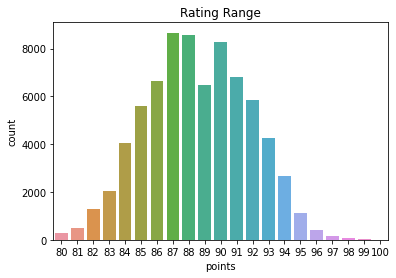

In [ ]:
plt.title('Rating Range')
sns.countplot(df['points'])

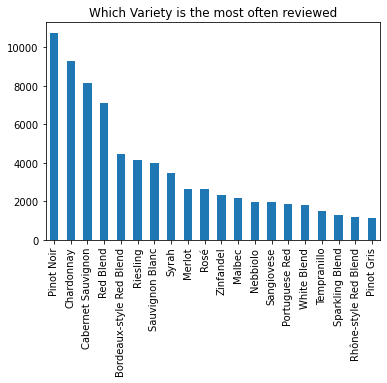

In [ ]:
plt.title("Which Variety is the most often reviewed")
df['variety'].value_counts().head(20).plot.bar()

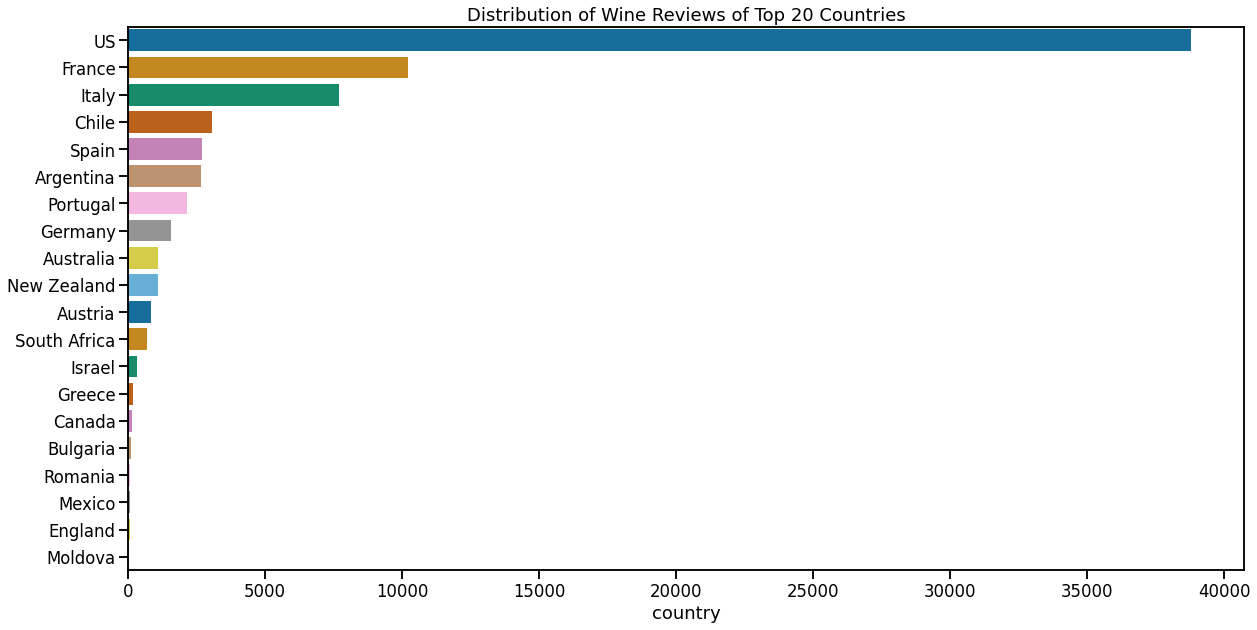

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(20,10))
cnt = df['country'].value_counts().to_frame()[0:20]
#plt.xscale('log')
sns.barplot(x= cnt['country'], y =cnt.index, data=cnt, palette='colorblind',orient='h')
plt.title('Distribution of Wine Reviews of Top 20 Countries');

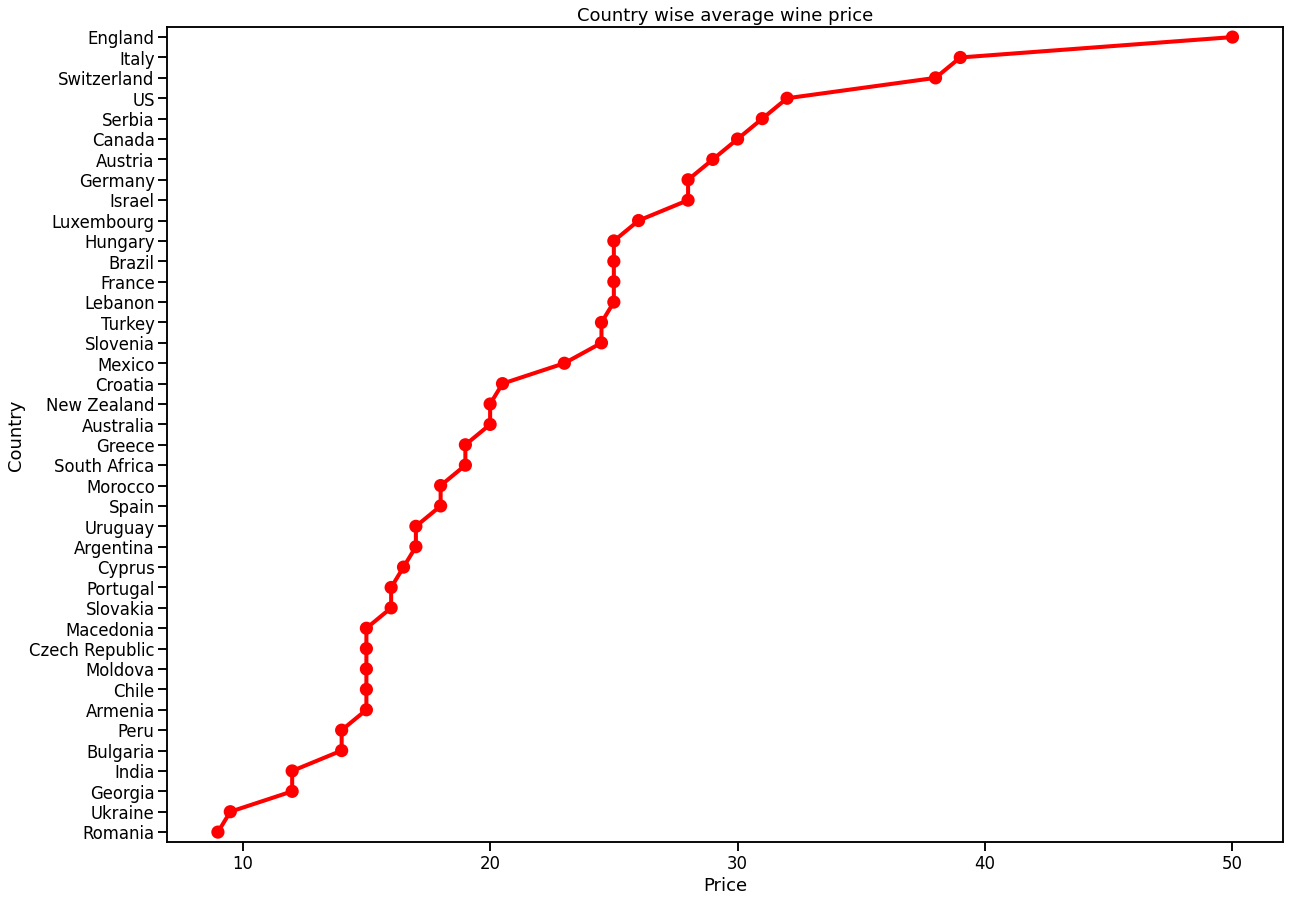

In [ ]:
cnt = df.groupby(['country',]).median()['price'].sort_values(ascending=False).to_frame()

plt.figure(figsize=(20,15))
sns.pointplot(x = cnt['price'] ,y = cnt.index ,color='r',orient='h',markers='o')
plt.title('Country wise average wine price')
plt.xlabel('Price')
plt.ylabel('Country');

Text(0.5, 0, '')

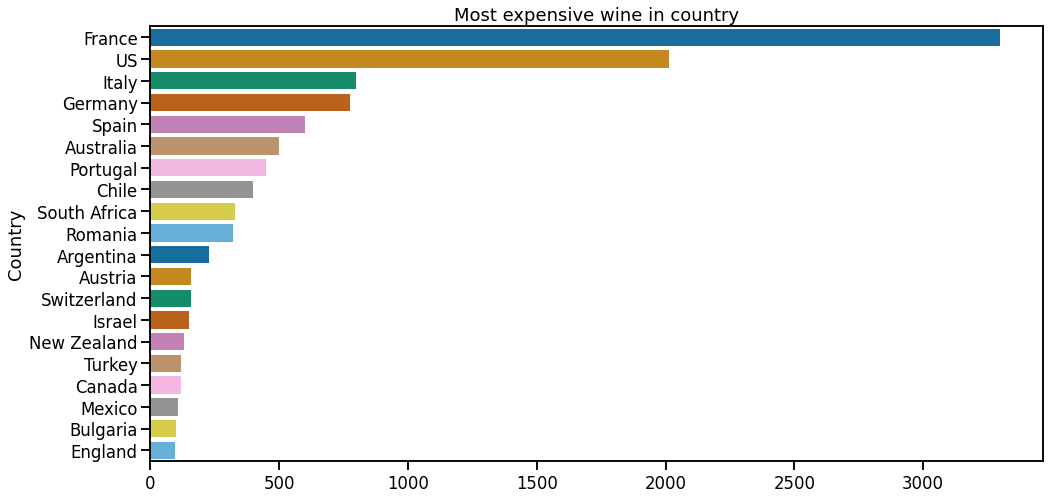

In [ ]:
plt.figure(figsize=(16,8))

cnt = df.groupby(['country'])['price'].max().sort_values(ascending=False).to_frame()[:20]
g2 = sns.barplot(x = cnt['price'], y = cnt.index, palette= 'colorblind')
g2.set_title('Most expensive wine in country')
g2.set_ylabel('Country')
g2.set_xlabel('')

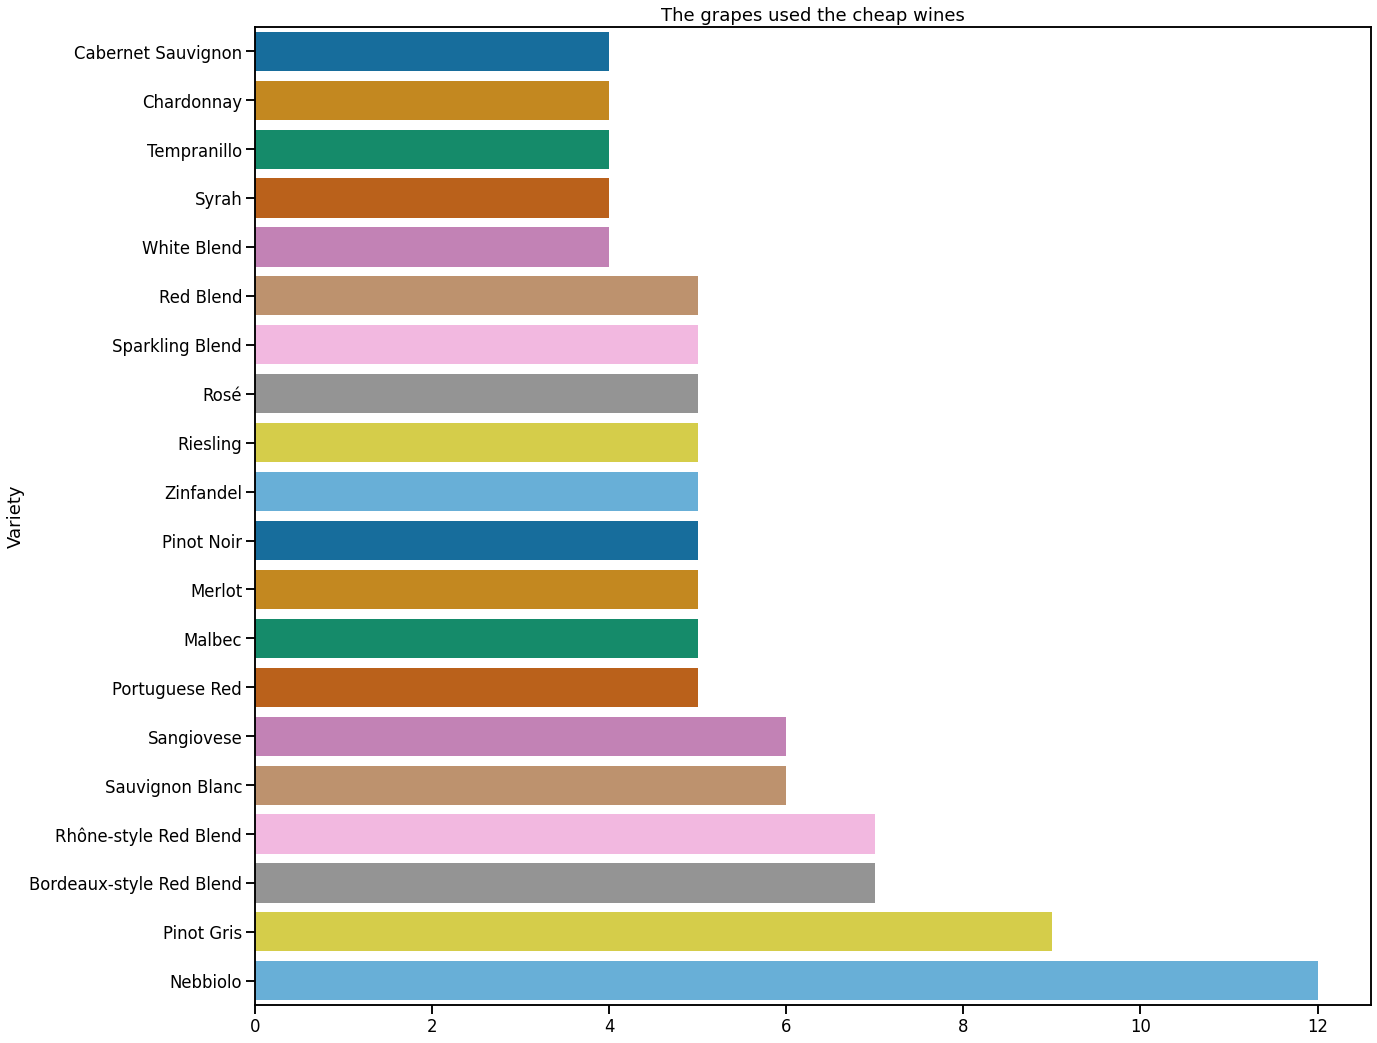

In [ ]:
sns.set_context("talk")
plt.figure(figsize=(20,18))
cnt = df.groupby(['variety'])['price'].min().sort_values(ascending=True).to_frame()[:20]
g2 = sns.barplot(x = cnt['price'], y = cnt.index, palette= 'colorblind')
g2.set_title('The grapes used the cheap wines')
g2.set_ylabel('Variety')
g2.set_xlabel('')
plt.show()

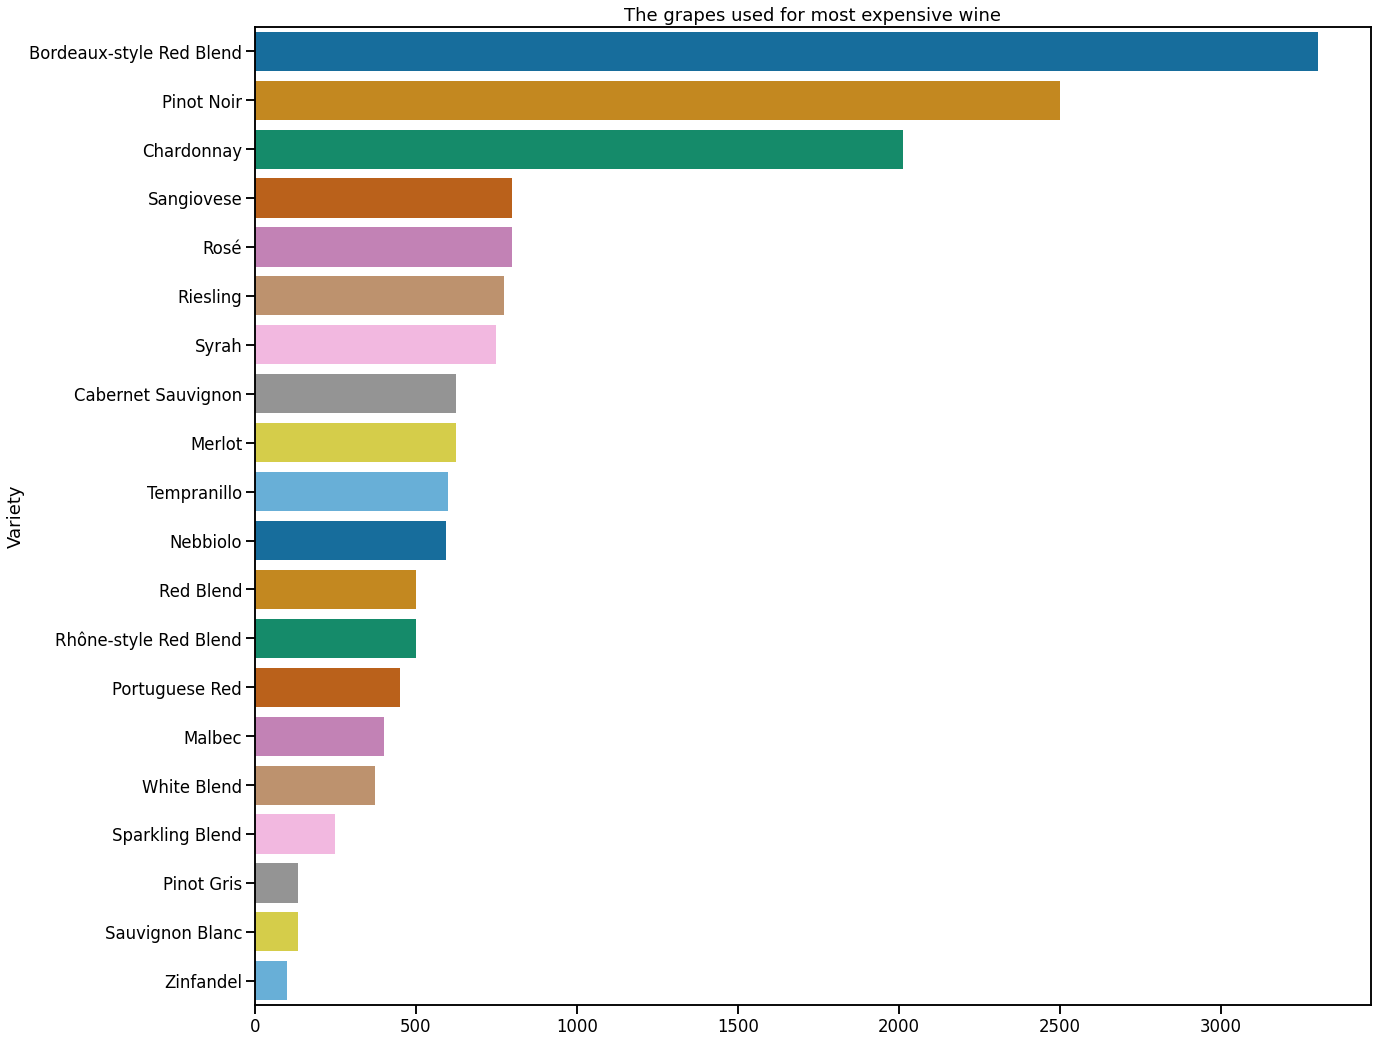

In [ ]:
plt.figure(figsize=(20,18))
cnt = df.groupby(['variety'])['price'].max().sort_values(ascending=False).to_frame()[:25]
g2 = sns.barplot(x = cnt['price'], y = cnt.index, palette= 'colorblind')
g2.set_title('The grapes used for most expensive wine')
g2.set_ylabel('Variety')
g2.set_xlabel('')
plt.show()

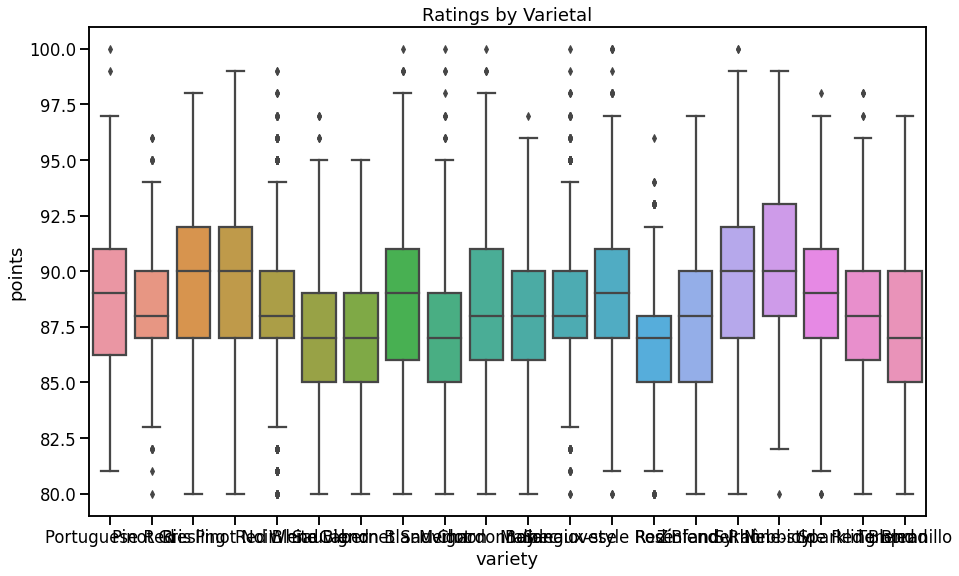

In [ ]:
plt.figure(figsize=(15,9))
plt.title("Ratings by Varietal")
sns.boxplot(x='variety', y='points', data=df)

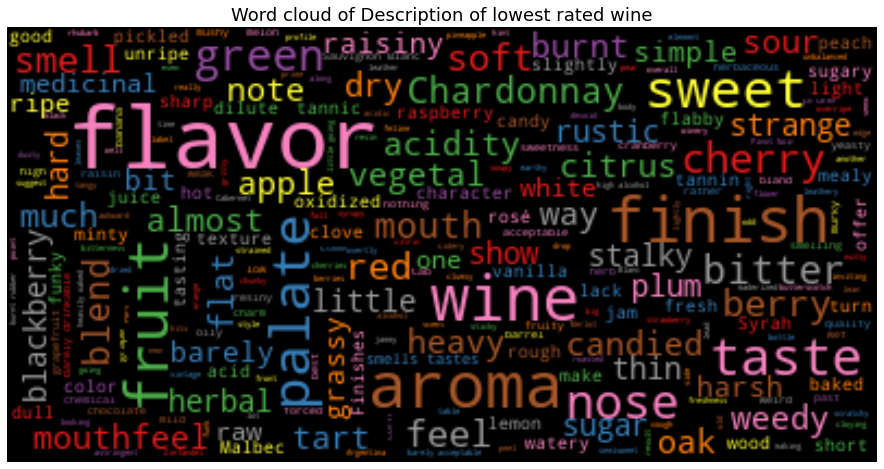

In [ ]:
sns.set_context("talk")
plt.figure(figsize= (16,8))
plt.title('Word cloud of Description of lowest rated wine')
wc = WordCloud(max_words=1000,max_font_size=40,background_color='black', stopwords = STOPWORDS,colormap='Set1')
wc.generate(' '.join(df[df['points']==80]['description']))
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show()

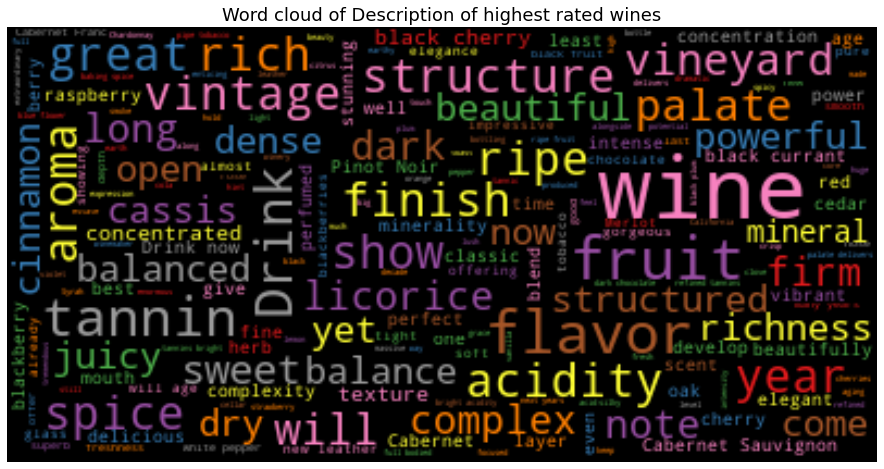

In [ ]:
plt.figure(figsize= (16,8))
plt.title('Word cloud of Description of highest rated wines')
wc = WordCloud(max_words=1000,max_font_size=40,background_color='black', stopwords = STOPWORDS,colormap='Set1')
wc.generate(' '.join(df[df['points']>=97]['description']))
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show()

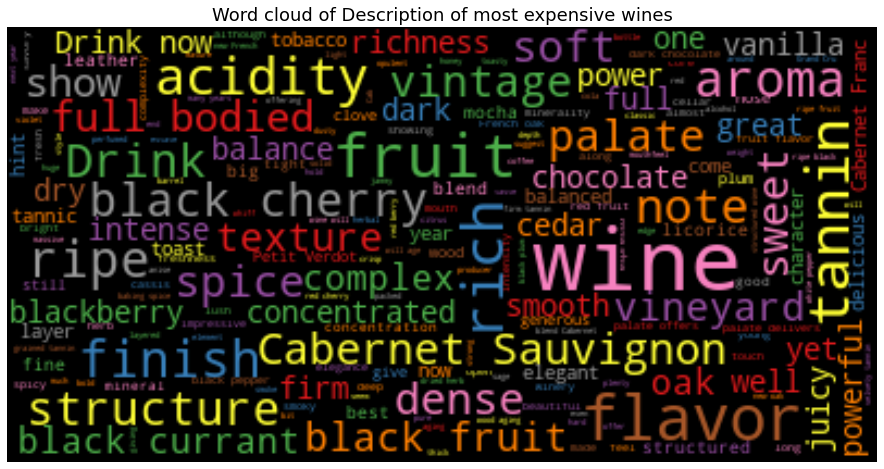

In [ ]:
plt.figure(figsize= (16,8))
plt.title('Word cloud of Description of most expensive wines')
wc = WordCloud(max_words=1000,max_font_size=40,background_color='black', stopwords = STOPWORDS,colormap='Set1')
wc.generate(' '.join(df[df['price']>=108]['description']))
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show()

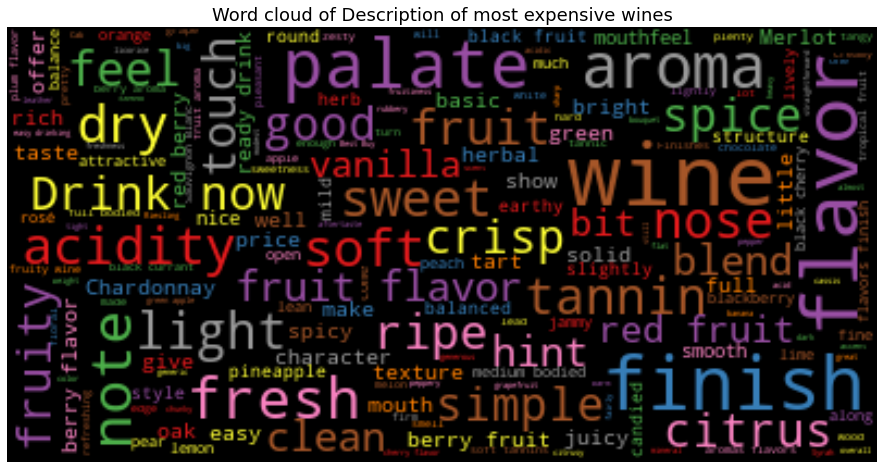

In [ ]:
plt.figure(figsize= (16,8))
plt.title('Word cloud of Description of most expensive wines')
wc = WordCloud(max_words=1000,max_font_size=40,background_color='black', stopwords = STOPWORDS,colormap='Set1')
wc.generate(' '.join(df[df['price']<=10]['description']))
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show()

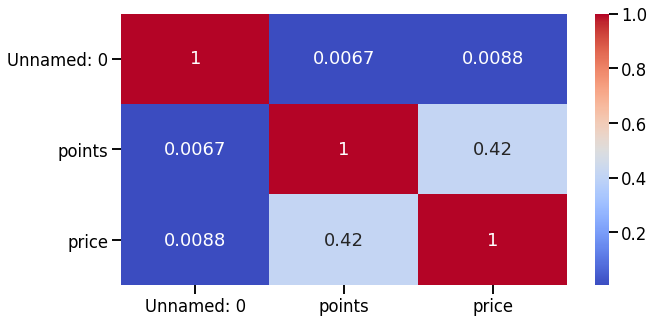

In [ ]:
plt.figure(figsize=(10,5))
c= df.corr()
sns.heatmap(c,cmap="coolwarm",annot=True)

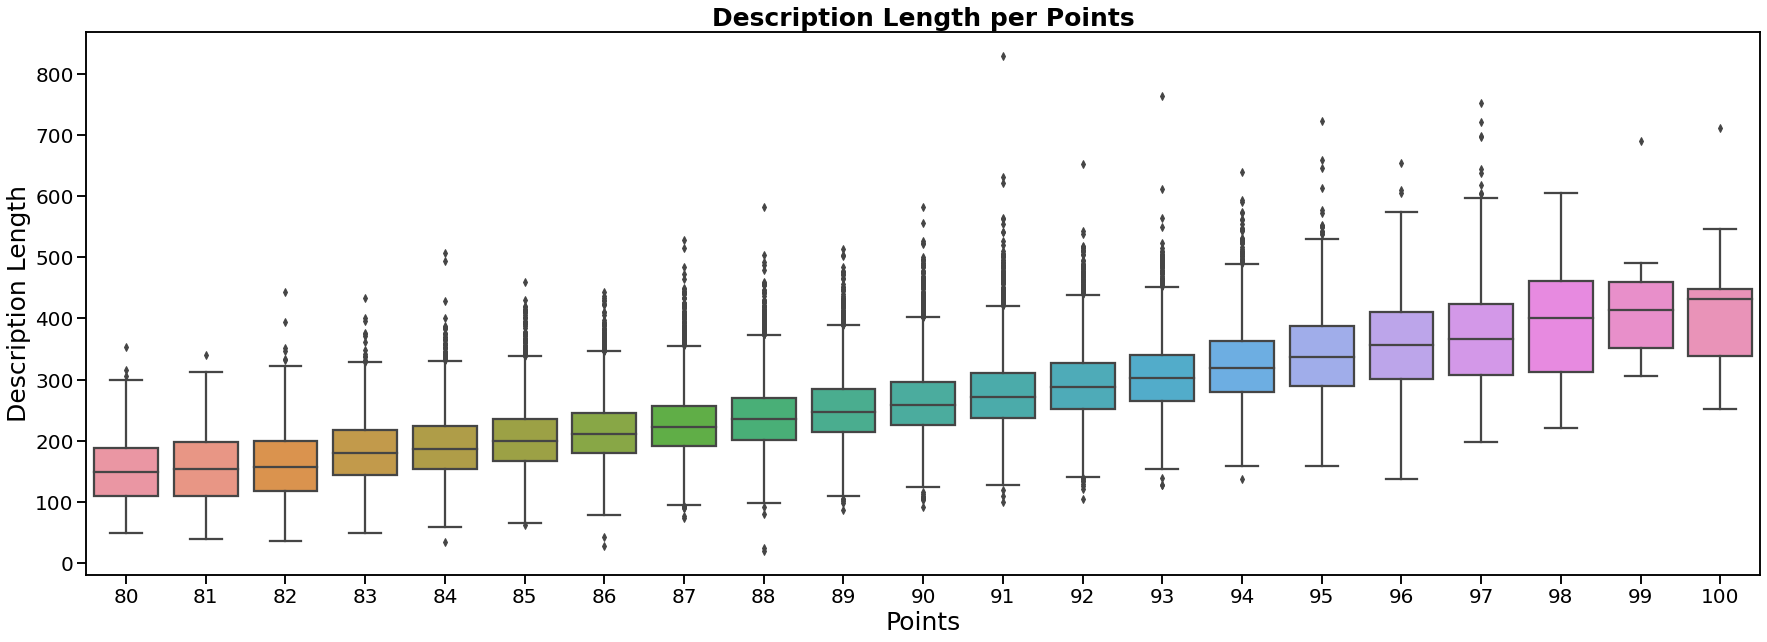

In [ ]:
df = df.assign(description_length = df['description'].apply(len))
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='points', y='description_length', data=df)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Points', fontweight="bold", size=25) # Title
ax.set_ylabel('Description Length', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
plt.show()

In [ ]:
df.shape

(73691, 10)

In [ ]:
df.columns

Index(['Unnamed: 0', 'country', 'description', 'points', 'price', 'province',
       'title', 'variety', 'winery', 'description_length'],
      dtype='object')

In [ ]:
df.description_length

1         227
2         186
3         199
4         249
15        176
         ... 
129963    345
129965    211
129966    227
129967    233
129969    216
Name: description_length, Length: 73691, dtype: int64

In [ ]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [ ]:
stopwords = ['wine', 'flavor', 'flavors', 'notes', 'offers', 'enjoy', 'drink', 'bottling',
                           'really', 'reveal', 'picked', 'partner', 'thanks', 'grown', 'gain', 
                           'thanks', 'percentage', 'buy', 'mid', 'gain', 'bottle', 'amid', 'available',
                           'come', 'aspect', 'try', 'pinot', 'noir', 'chardonnay','cabernet', 'sauvignon',
                            'red','white','bordeaux', 'riesling', 'blanc','syrah','merlot',
                            'rose', 'zinfandel','malbec','nebbiolo','sangiovese', 'tempranillo','sparkling',
                            'rhone','gris', 'riesling', 'sirah', 'petite', 'petit', 'make']
stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)

In [ ]:
from random import sample
sample = df.sample(20000, random_state = 42)
sample_desc = sample['description']
sample['variety'].value_counts()

Pinot Noir                  2897
Chardonnay                  2557
Cabernet Sauvignon          2237
Red Blend                   1941
Bordeaux-style Red Blend    1186
Sauvignon Blanc             1068
Riesling                    1063
Syrah                        918
Merlot                       782
Rosé                         729
Zinfandel                    619
Malbec                       597
Nebbiolo                     546
Sangiovese                   513
White Blend                  503
Portuguese Red               492
Tempranillo                  391
Sparkling Blend              351
Rhône-style Red Blend        306
Pinot Gris                   304
Name: variety, dtype: int64

In [ ]:
tf_vect = TfidfVectorizer(stop_words = stop_words, tokenizer=tokenize, max_features = 2000)
X_sample = tf_vect.fit_transform(sample_desc)
words_sample = tf_vect.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'avail', 'becam', 'becaus', 'becom', 'befor', 'besid', 'bottl', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'note', 'noth', 'nowher', 'offer', 'onc', 'onli', 'otherwis', 'ourselv', 'percentag', 'perhap', 'pick', 'pleas', 'realli', 'riesl', 'sangioves', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'sparkl', 'thank', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'tri', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'you

In [ ]:
kmeans = KMeans(n_clusters = 20, n_init = 5, n_jobs = -1)
kmeans.fit(X_sample)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=5, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-16:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words_sample[word] for word in centroid))

0 : fruit, cherri, finish, tannin, berri, blend, vineyard, spice, soft, note, acid, aroma, dri, vintag, offer
1 : black, cherri, pepper, fruit, plum, palat, tannin, dark, aroma, finish, nose, spice, blackberri, chocol, licoric
2 : cherri, raspberri, cola, silki, sweet, dri, acid, oak, soft, good, simpl, spice, candi, rich, year
3 : berri, herbal, plum, aroma, finish, feel, palat, note, oak, fruit, earthi, spice, cassi, tast, bake
4 : blackberri, currant, tannin, oak, chocol, rich, dri, cherri, soft, sweet, tannic, ripe, year, black, good
5 : lemon, lime, palat, fresh, appl, acid, finish, nose, grapefruit, zest, dri, meyer, aroma, miner, peach
6 : espresso, palat, tannin, toast, alongsid, aroma, oak, coffe, black, offer, dri, cherri, astring, licoric, bean
7 : dre, mourv, grenach, blend, pepper, counois, cinsault, fruit, black, ne, rh, spice, cherri, finish, aroma
8 : bodi, medium, textur, finish, aroma, fruit, cherri, note, light, tannin, like, ripe, soft, oak, balanc
9 : appl, pear, g

In [ ]:
sample['cluster'] = kmeans.labels_

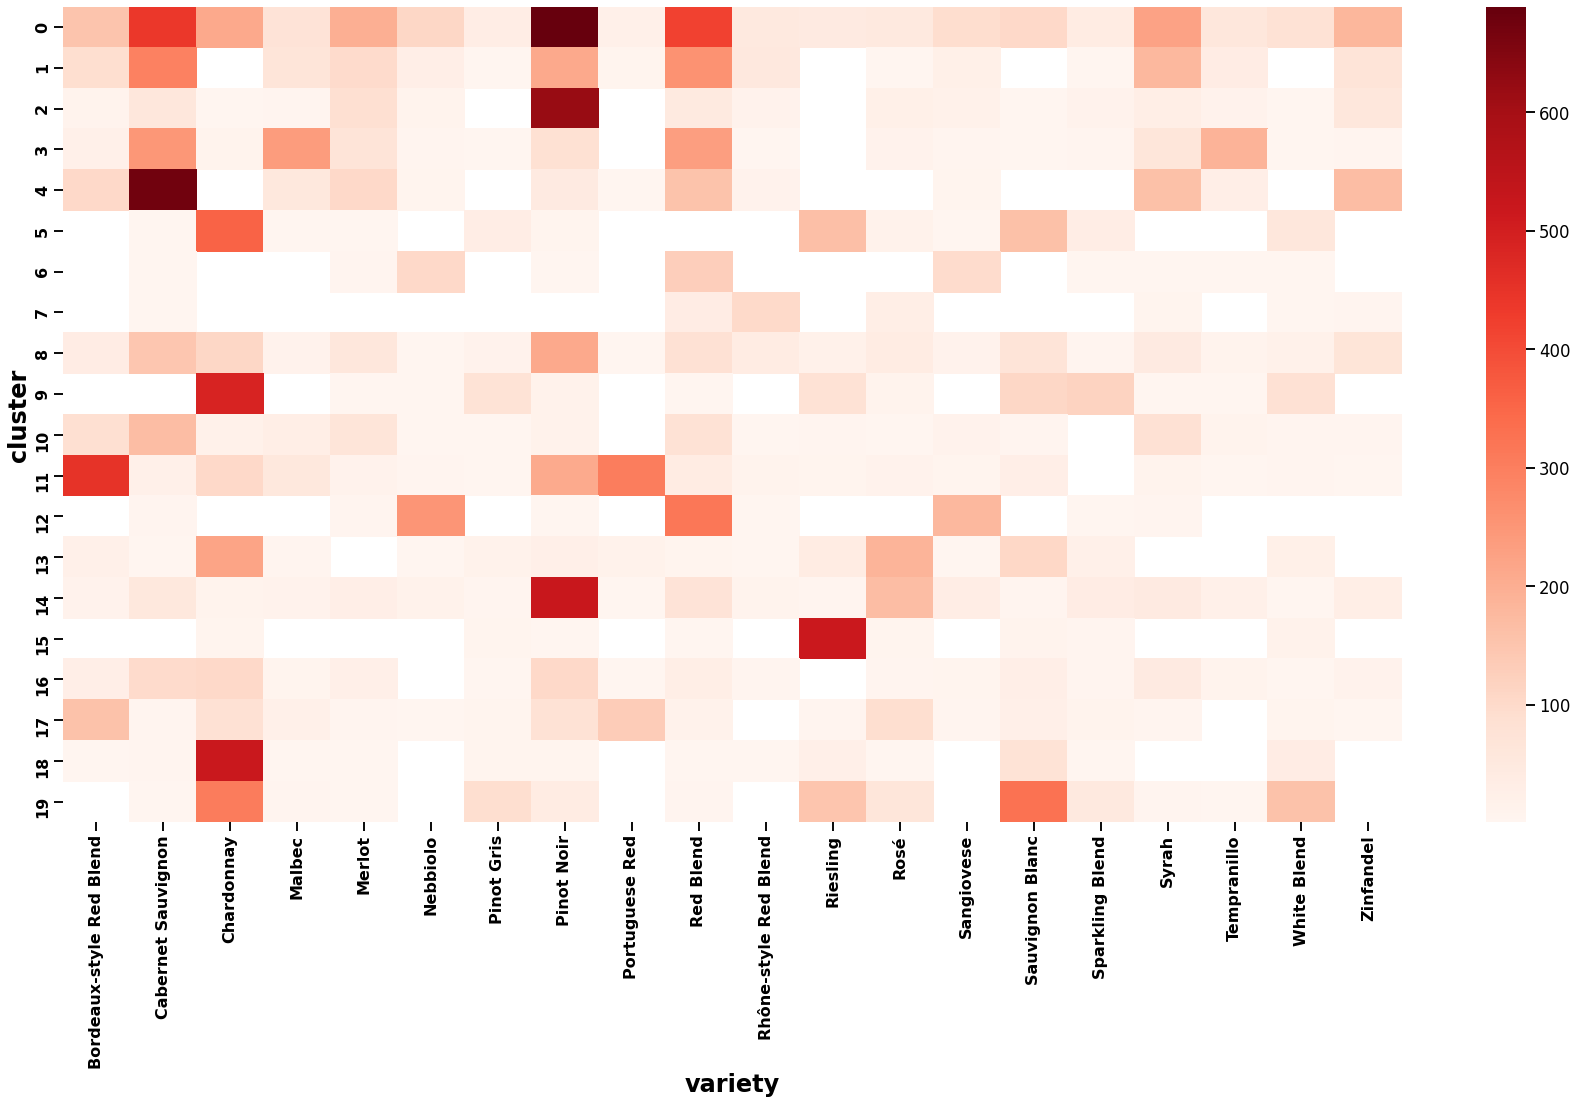

In [ ]:
clusters = sample.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
SIA = SentimentIntensityAnalyzer()

# Applying Model, Variable Creation
sentiment = df.sample(15000).copy()
sentiment['polarity_score']=sentiment.description.apply(lambda x:SIA.polarity_scores(x)['compound'])
sentiment['neutral_score']=sentiment.description.apply(lambda x:SIA.polarity_scores(x)['neu'])
sentiment['negative_score']=sentiment.description.apply(lambda x:SIA.polarity_scores(x)['neg'])
sentiment['positive_score']=sentiment.description.apply(lambda x:SIA.polarity_scores(x)['pos'])

sentiment['sentiment']= np.nan
sentiment.loc[sentiment.polarity_score>0,'sentiment']='POSITIVE'
sentiment.loc[sentiment.polarity_score==0,'sentiment']='NEUTRAL'
sentiment.loc[sentiment.polarity_score<0,'sentiment']='NEGATIVE'

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def sentiment_analyzer_scores(sentence):
    score = SIA.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

print(sentiment_analyzer_scores("Hurray"))
print(sentiment_analyzer_scores("I love You"))
print(sentiment_analyzer_scores("WHAT A BORING DAY"))

df['price']

Hurray---------------------------------- {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}
None
I love You------------------------------ {'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
None
WHAT A BORING DAY----------------------- {'neg': 0.535, 'neu': 0.465, 'pos': 0.0, 'compound': -0.3182}
None


1         15.0
2         14.0
3         13.0
4         65.0
15        24.0
          ... 
129963    20.0
129965    28.0
129966    28.0
129967    75.0
129969    32.0
Name: price, Length: 73691, dtype: float64

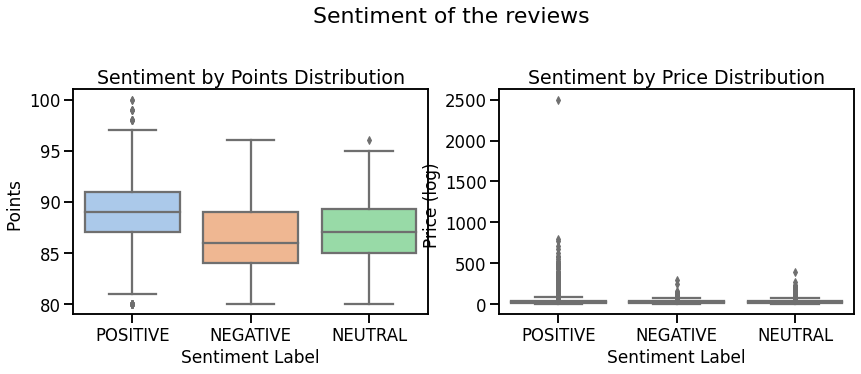

In [ ]:
plt.figure(figsize=(14,5))
plt.suptitle('Sentiment of the reviews', size=22)

plt.subplot(121)
ax = sns.boxplot(x='sentiment', y='points', data=sentiment,palette = 'pastel')
ax.set_title("Sentiment by Points Distribution", fontsize=19)
ax.set_ylabel("Points ", fontsize=17)
ax.set_xlabel("Sentiment Label", fontsize=17)

plt.subplot(122)
ax1= sns.boxplot(x='sentiment', y='price', data=sentiment,palette = 'pastel')
ax1.set_title("Sentiment by Price Distribution", fontsize=19)
ax1.set_ylabel("Price (log) ", fontsize=17)
ax1.set_xlabel("Sentiment Label", fontsize=17)

plt.subplots_adjust(top = 0.75, wspace=.2)
plt.show()

In [ ]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
key = "pinot cabernet "
choices = df['title']
matches = (process.extract(key, choices, scorer = fuzz.ratio, limit = 5))
print("\n".join(map(str, matches)))

('ZD 2014 Pinot Noir (Carneros)', 52, 24833)
('ZD 2012 Pinot Noir (Carneros)', 52, 33867)
('ZD 2007 Pinot Noir (Carneros)', 52, 126680)
('Peirano 1999 Cabernet Sauvignon (Lodi)', 51, 104792)
('Piazzano 2011  Chianti', 50, 64302)


In [ ]:
sample = df.sample(n=20000, random_state=42)
sample = sample.reset_index()
sample = sample.drop(['index'], axis = 1)
sample.shape

(20000, 10)

In [ ]:
stopwords = ['wine', 'flavor', 'flavors', 'notes', 'offers', 'enjoy', 'drink', 'bottling',
                           'really', 'reveal', 'picked', 'partner', 'thanks', 'grown', 'gain', 
                           'thanks', 'percentage', 'buy', 'mid', 'gain', 'bottle', 'amid', 'available',
                           'come', 'aspect', 'try', 'pinot', 'noir', 'chardonnay','cabernet', 'sauvignon',
                            'red','white','bordeaux', 'riesling', 'blanc','syrah','merlot',
                            'rose', 'zinfandel','malbec','nebbiolo','sangiovese', 'tempranillo','sparkling',
                            'rhone','gris', 'riesling', 'sirah', 'petite', 'petit', 'make']
stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)

In [ ]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

tf = TfidfVectorizer(stop_words=stop_words,tokenizer=tokenize, max_features = 2000)
tf_matrix = tf.fit_transform(sample['description'])
tf_matrix


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'avail', 'becam', 'becaus', 'becom', 'befor', 'besid', 'bottl', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'note', 'noth', 'nowher', 'offer', 'onc', 'onli', 'otherwis', 'ourselv', 'percentag', 'perhap', 'pick', 'pleas', 'realli', 'riesl', 'sangioves', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'sparkl', 'thank', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'tri', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'you

<20000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 396966 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tf_matrix, tf_matrix)
cosine = pd.DataFrame(cosine_sim)
cosine.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,19960,19961,19962,19963,19964,19965,19966,19967,19968,19969,19970,19971,19972,19973,19974,19975,19976,19977,19978,19979,19980,19981,19982,19983,19984,19985,19986,19987,19988,19989,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,1.000000,0.011451,0.015741,0.007518,0.000000,0.000000,0.008807,0.046729,0.000000,0.075163,0.000000,0.000000,0.000000,0.149241,0.079061,0.099818,0.033415,0.065349,0.052203,0.050687,0.010162,0.052282,0.026856,0.014989,0.019053,0.036091,0.000000,0.000000,0.000000,0.117597,0.041862,0.053335,0.000000,0.026721,0.025861,0.062767,0.022751,0.044247,0.112371,0.006671,...,0.106884,0.000000,0.000000,0.009339,0.019911,0.039907,0.096985,0.010563,0.033246,0.000000,0.040099,0.044812,0.033967,0.066643,0.000000,0.041699,0.000000,0.073662,0.037164,0.000000,0.145777,0.008925,0.061561,0.021814,0.042329,0.020050,0.039860,0.049925,0.000000,0.012851,0.008851,0.032212,0.007963,0.054284,0.032443,0.061253,0.000000,0.141455,0.174808,0.000000
1,0.011451,1.000000,0.016025,0.007654,0.000000,0.015346,0.008967,0.109476,0.044786,0.043736,0.000000,0.013772,0.000000,0.031726,0.012270,0.067698,0.000000,0.038862,0.021374,0.000000,0.025926,0.017822,0.000000,0.120498,0.030320,0.000000,0.018355,0.000000,0.000000,0.058897,0.029813,0.055637,0.015035,0.000000,0.020613,0.031416,0.019854,0.019228,0.023673,0.020262,...,0.019936,0.000000,0.030691,0.023776,0.033783,0.034752,0.011387,0.010754,0.017253,0.012332,0.009849,0.046493,0.000000,0.025975,0.000000,0.023093,0.080802,0.027193,0.022826,0.000000,0.036190,0.036405,0.060260,0.022208,0.023864,0.020413,0.015886,0.000000,0.021894,0.032717,0.040453,0.000000,0.036352,0.052785,0.000000,0.069322,0.072813,0.147186,0.013857,0.021162
2,0.015741,0.016025,1.000000,0.010521,0.000000,0.058103,0.028852,0.014043,0.000000,0.080684,0.000000,0.000000,0.000000,0.017440,0.015018,0.029023,0.018830,0.018056,0.054954,0.000000,0.014222,0.008211,0.031685,0.020977,0.000000,0.000000,0.000000,0.000000,0.013123,0.020119,0.018276,0.058708,0.018465,0.015058,0.025228,0.014475,0.010891,0.023615,0.153659,0.009336,...,0.024485,0.133063,0.000000,0.013070,0.000000,0.019104,0.015653,0.014783,0.023717,0.000000,0.013539,0.101923,0.000000,0.000000,0.000000,0.000000,0.000000,0.037380,0.126238,0.016924,0.016675,0.012490,0.000000,0.050994,0.013118,0.028060,0.040706,0.000000,0.000000,0.084115,0.028995,0.000000,0.026086,0.015661,0.151176,0.043060,0.021603,0.018216,0.000000,0.000000
3,0.007518,0.007654,0.010521,1.000000,0.000000,0.049963,0.101328,0.036368,0.044237,0.036322,0.019602,0.043692,0.081794,0.008330,0.034061,0.038233,0.186290,0.028444,0.035600,0.028248,0.038528,0.070243,0.015253,0.010019,0.098000,0.007532,0.066024,0.023989,0.013454,0.043981,0.009201,0.030793,0.018931,0.039159,0.070382,0.076611,0.044483,0.000000,0.073076,0.004459,...,0.000000,0.058813,0.059950,0.023904,0.042462,0.032647,0.007476,0.027037,0.011328,0.015474,0.006467,0.009104,0.019624,0.077764,0.009321,0.000000,0.000000,0.043545,0.047694,0.070721,0.076972,0.118527,0.026803,0.079572,0.006266,0.022872,0.019933,0.090849,0.000000,0.030735,0.065171,0.079478,0.056662,0.082294,0.027706,0.018888,0.010875,0.036358,0.025942,0.043105
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.102885,0.000000,0.000000,0.072384,0.030286,0.028256,0.000000,0.164225,0.000000,0.037982,0.042045,0.000000,0.000000,0.000000,0.000000,0.297870,0.015995,0.025497,0.000000,0.047008,0.000000,0.000000,0.000000,0.096110,0.033895,0.000000,0.020144,0.000000,0.000000,0.000000,0.000000,0.000000,0.034308,0.000000,0.000000,...,0.035571,0.058649,0.000000,0.029524,0.000000,0.043153,0.000000,0.000000,0.049887,0.141478,0.000000,0.000000,0.000000,0.037771,0.000000,0.036154,0.110683,0.000000,0.028344,0.000000,0.000000,0.000000,0.040732,0.051761,0.055186,0.047576,0.124913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070150,0.000000,0.000000,0.000000,0.049277,0.128774
5,0.000000,0.01

In [ ]:
indices = pd.Series(sample.index, index=sample['title']).drop_duplicates()

In [ ]:
pick_one = ''
def get_choices(key):
    
    choices = sample['title']    
    
    #gets the top five closest matches ands asks the user to pick one
    matches = (process.extract(key, choices, scorer = fuzz.ratio, limit = 5))
    print("\n Here are the 5 closest matches...Pick one for the recommender to use. \n")
    print("\n".join(map(str, matches)))
    
    global pick_one
    pick_one = input("Enter wine here: ")
    
    print("\n Okay, here are 10 other wines that are like", pick_one.title())
    
    def fuzzy_match(key):
    
        choices = sample['title']    

        #returns the top matching choice
        return process.extractOne(key, choices, scorer = fuzz.token_sort_ratio, score_cutoff = 50)[0]

    #assigning the top choice to title since that is an input for the next function
    title = fuzzy_match(pick_one)

    def get_recommendations2(title, cosine_sim=cosine_sim):

        # Get the index of the wine that matches the title
        idx = indices[title]

        # Get the pairwsie similarity scores of all wines with that wine
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort the wines based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 10 most similar wines
        sim_scores = sim_scores[0:11] #included the 0-th index so I can see the original wine too

        # Get the wines indices
        wine_indices = [i[0] for i in sim_scores]

        # Return the top 10 most similar wines
        return sample['title'].iloc[wine_indices]

    results = get_recommendations2(title)
    print(results)

In [ ]:
wine = input('What wine would you like to search for?')
get_choices(wine)

What wine would you like to search for?pinot niar

 Here are the 5 closest matches...Pick one for the recommender to use. 

('Bomb 2009 Pinot Noir', 60, 3837)
('Animale 2014 Pinot Noir', 55, 12663)
('Macindoe 2008 Pinot Noir', 53, 2090)
('ZD 2012 Pinot Noir (Carneros)', 53, 17002)
('ZD 2007 Pinot Noir (Carneros)', 53, 18850)
Enter wine here: Animale 2014 Pinot Noir

 Okay, here are 10 other wines that are like Animale 2014 Pinot Noir
12663                              Animale 2014 Pinot Noir
8472                Spangler 2013 Malbec (Southern Oregon)
19766    Domaine Alfred 2005 Califa Pinot Noir (Edna Va...
16485    Santa Barbara Winery 2012 Pinot Noir (Sta. Rit...
16166    Mount Baker 2007 Barrel Select Syrah (Yakima V...
572      Joseph Swan Vineyards 2007 Zeigler Vineyard Zi...
7493     Foxen 2010 7200 Grassini Vineyard Cabernet Sau...
17787             Kokomo 2009 Zinfandel (Dry Creek Valley)
13243    La Fenêtre 2006 Cargasacchi Jalama Vineyard Pi...
11586    Ermisch 2012 Erendira'

In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:11] #included the 0-th index so I can see the original wine too
    wine_indices = [i[0] for i in sim_scores]
    return sample['title'].iloc[wine_indices]

In [ ]:
get_recommendations('Spangler 2013 Malbec (Southern Oregon)')

8472                Spangler 2013 Malbec (Southern Oregon)
19688       Wise Villa 2011 Tempranillo (Sierra Foothills)
12663                              Animale 2014 Pinot Noir
11739     Irvine Family Vineyards 2014 Pinot Noir (Oregon)
2725     Moorooduc 2013 The Moorooduc McIntyre Chardonn...
7493     Foxen 2010 7200 Grassini Vineyard Cabernet Sau...
88       Coquelicot 2011 Reserve Cabernet Sauvignon (Sa...
8829       Gilles Flacher 2012 Terra Louis  (Saint-Joseph)
9070     Steppe Cellars 2008 StoneTree Vineyard Malbec ...
17787             Kokomo 2009 Zinfandel (Dry Creek Valley)
5801           Ara 2008 Composite Pinot Noir (Marlborough)
Name: title, dtype: object

In [ ]:
t1 = sample.loc[[17075, 17202, 518, 4958, 10217, 4904, 16708, 18538, 14569, 3523],['description', 'title']]
t1

,description,title
17075,"Dry, bright and light, with simple, modest fru...",Trefethen 2002 Riesling (Napa Valley)
17202,Punchbowl sweetness and pineapple aromas come ...,Arauco 2012 Sauvignon Blanc (Central Valley)
518,"Aromas of banana, peach and citrus fruits are ...",Marco Zunino 2014 Chardonnay (Mendoza)
4958,"This clean, mild quaffer offers basic white-fr...",Mariposa 2016 Chardonnay (San Juan)
10217,"Notes of apple, yellow peach and pear are savo...",Harbes Family Vineyard 2014 Steel Fermented Ch...
4904,With Chardonnay from Provence the dominant par...,Simonnet-Febvre 2014 100 Series Chardonnay (Vi...
16708,The faux French name and labeling notwithstand...,Domaine Loubejac 2014 Willamette Chardonnay (W...
18538,Basic tropical-fruit aromas settle on pineappl...,Zolo 2016 Sustainably Farmed Estate Grown and ...
14569,This round yet direct Cava offers stone-fruit ...,Marqués de la Concordia 2012 MM Reserva de la ...
3523,Light weight and somewhat sweet with flavors o...,Binyamina 2009 Reserve Kosher Sauvignon Blanc ...


In [ ]:
get_recommendations("Kriter NV Eclat Carmin Rosé Sparkling (France)")

878         Kriter NV Eclat Carmin Rosé Sparkling (France)
12138    Ugly Duckling 2010 Cabernet Sauvignon (Califor...
14647    Armanino Family Cellars 2012 The Ringneck Pino...
17842    Proulx 2013 Resistance Willow Creek Farm Rosé ...
4779     Hayman & Hill 2005 Reserve Selection Cabernet ...
5333     Castillo De Feliciana 2010 Phinny Hill Vineyar...
547                     Anne Amie 2012 Pinot Gris (Oregon)
13177    Tres Palacios 2013 Family Vintage Cabernet Sau...
15542             Croze 2013 Cabernet Sauvignon (Oakville)
9857     TerraNoble 2006 Gran Reserva Merlot (Maule Val...
2138      Tolosa 2014 Estate Sauvignon Blanc (Edna Valley)
Name: title, dtype: object

In [ ]:
t2 = sample.loc[[878, 12138, 14647, 17842, 13421, 4779, 11471, 5333, 547, 13177, 4938],['description', 'title']]
t2

,description,title
878,"Light and refreshing, with hints of berries an...",Kriter NV Eclat Carmin Rosé Sparkling (France)
12138,"A big letdown after the 2009, this is a simple...",Ugly Duckling 2010 Cabernet Sauvignon (Califor...
14647,"Juicy and big-bodied, this is a balanced expre...",Armanino Family Cellars 2012 The Ringneck Pino...
17842,This bottling starts with a pretty nose of pea...,Proulx 2013 Resistance Willow Creek Farm Rosé ...
13421,Tastes soft and a little tired at the age of s...,Collier Falls 2004 Hillside Estate Cabernet Sa...
4779,"A little rough around the edges, with some gre...",Hayman & Hill 2005 Reserve Selection Cabernet ...
11471,"Soft notes of apple are bedded on a creamy, bi...",Willm NV Blanc de Noirs Brut Pinot Noir (Alsace)
5333,This lightly aromatic Malbec has notes of plum...,Castillo De Feliciana 2010 Phinny Hill Vineyar...
547,"This is a young, yeasty wine with a scent of f...",Anne Amie 2012 Pinot Gris (Oregon)
13177,"Although this is herbal on the nose, there are...",Tres Palacios 2013 Family Vintage Cabernet Sau...


In [ ]:
!pip install flask



In [ ]:
import flask
from IPython import get_ipython

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-07-08 04:04:24--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.45.37.112, 34.193.24.98, 3.223.73.198, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.45.37.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  17.2MB/s    in 0.8s    

2021-07-08 04:04:25 (17.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
!pip install colabcode
from colabcode import ColabCode
server = ColabCode(port=10000, code=False)
                   

     |████████████████████████████████| 8.3MB 7.5MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 747kB 32.4MB/s 
     |████████████████████████████████| 399kB 23.7MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 430kB 32.0MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 122kB 44.5MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.0.5-cp37-none-any.whl size=19262 sha256=c879933ad9df6ce3703a18519338c6d620cf401dc765adbfb5a569b68adb20b3
  Stored in directory: /root/.cache/pip/wheels/0c/13/64/5ebbcc22eaf53fdf5766b397c1fb17c83f5775fdccf0ea1b88
Successfully built pyngrok
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1

In [ ]:
!pip install fastapi
!pip install flask
from fastapi import FastAPI
from flask import Flask, render_template, request, redirect
from typing import Dict
from fastapi import Depends, FastAPI
from pydantic import BaseModel

In [ ]:
class input(BaseModel):
  txt: str

app = FastAPI()
@app.get('/')
def index():
    return {'message': 'Hello Kudos!!'}

@app.post('/predict')
def get_wine_recommendation(data: input):
    received = data.dict()
    txt = received('txt')
    pred_name = get_recommendations(txt)
    return {'prediction': pred_name}

In [ ]:
from colabcode import ColabCode
server = ColabCode(port=10000, code=False)
pred_name = get_recommendations("Spangler 2013 Malbec (Southern Oregon)")
pred_name

8472                Spangler 2013 Malbec (Southern Oregon)
19688       Wise Villa 2011 Tempranillo (Sierra Foothills)
12663                              Animale 2014 Pinot Noir
11739     Irvine Family Vineyards 2014 Pinot Noir (Oregon)
2725     Moorooduc 2013 The Moorooduc McIntyre Chardonn...
7493     Foxen 2010 7200 Grassini Vineyard Cabernet Sau...
88       Coquelicot 2011 Reserve Cabernet Sauvignon (Sa...
8829       Gilles Flacher 2012 Terra Louis  (Saint-Joseph)
9070     Steppe Cellars 2008 StoneTree Vineyard Malbec ...
17787             Kokomo 2009 Zinfandel (Dry Creek Valley)
5801           Ara 2008 Composite Pinot Noir (Marlborough)
Name: title, dtype: object

In [ ]:
server.run_app(app=app)

Public URL: NgrokTunnel: "https://14e256cea61f.ngrok.io" -> "http://localhost:10000"


INFO:     Started server process [64]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:10000 (Press CTRL+C to quit)


INFO:     2409:4043:2382:a035:f94e:73c9:d3c1:457c:0 - "GET / HTTP/1.1" 200 OK
INFO:     2409:4043:2382:a035:f94e:73c9:d3c1:457c:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     202.88.147.196:0 - "GET / HTTP/1.1" 200 OK
INFO:     2409:4043:2382:a035:f94e:73c9:d3c1:457c:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     42.106.160.202:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     42.106.160.202:0 - "GET /openapi.json HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [64]
